# Form factor to total density prediction model training
This notebook shows how a deep learning model can be trained to predict total density profiles from form factors. 
It contains the following steps: 
1) Download the data using the [NMR lipids API](https://nmrlipids.github.io/databankLibrary.html). 
2) Preprocess data for the machine learning pipeline.
3) Training and evaluating the performance of the neural network.

Variable descriptions from the [NMRlipids databank](https://nmrlipids.github.io/listOfFiles.html#):
* Total densities: Total electron densities calculated with calc_FormFactors.py and stored in /Data/Simulations for all simulations. X-axis units are nm and y-axis units e/nm3.
* Form factors: X-ray scattering calculated with calc_FormFactors.py and stored in /Data/Simulations for all simulations. X-axis value unit are Å-1 and y-axis value units are e/nm2.

### Load the required libraries
Create a virtual environment using e.g. Poetry, and install the following libraries that will be needed. 
The code block below loads the required libraries if they are available in the virtual environment. If errors are generated, check the available libraries e.g. using pip list and install whichever libraries are missing.

In [1]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel

import tensorflow as tf
from tensorflow import keras
from keras import layers
from tensorflow.python.keras.callbacks import EarlyStopping

import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.simplefilter("ignore", ConvergenceWarning)

import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' # Set TensorFlow verbosity to lowest (only print errors)

### Initialize a random number generator
This will be used to split the data into training and test sets reproducibly. 

In [2]:
seed = 43715679334954349782040625626900603510
rng = np.random.default_rng(seed)

### Download and initialize the NMR lipids databank
To access the NMR lipids databank, clone the NMRlipids databank git repository into your working folder as explained at https://nmrlipids.github.io/databankLibrary.html: 
```
git clone https://github.com/NMRLipids/Databank.git
```
After doing so, the following code block sets up the databank for use.

In [3]:
# Initialize the NMR lipids databank
databankPath =  './Databank/'   # this is the local path for the cloned Databank git
sys.path.insert(1, databankPath + '/Scripts/BuildDatabank/')
from databankLibrary import *
from new_functions import *
systems = initialize_databank(databankPath)

Databank initialized from the folder: /Users/even/NMRlipids/Databank/Data/Simulations


Extract FF and TD from the databank
The TD have different ranges and resolutions in the x plane
We want to have all of them on the same form for the machine learning model
First extrapolate by padding to ensure all have the same extension in the x direction
Then interpolate with a Gaussian Process Regression to make sure the points are in the same place
The last steps also crops away some of the tails of the widest densities

In [4]:
all_ff = []
all_td_x = []
all_td_y = []

# Complete data should have form factors of length 1000 
required_form_factor_length = 1000

# Load form factors and total densities
for system in systems: 
    FFsim, TDsim = getFormFactorAndTotalDensityPair(system)

    if isinstance(FFsim, list) and isinstance(TDsim, list) and len(FFsim) == required_form_factor_length:
        ff = np.array([elem[1] for elem in FFsim])
        all_ff.append(ff)

        td_x = np.array([elem[0] for elem in TDsim])
        td_y = np.array([elem[1] for elem in TDsim])
        all_td_x.append(td_x)
        all_td_y.append(td_y)

assert len(all_ff) == len(all_td_x) == len(all_td_y)
N_experiments = len(all_ff)
print("Number of form factor and total density pairs:", N_experiments)

Number of form factor and total density pairs: 787


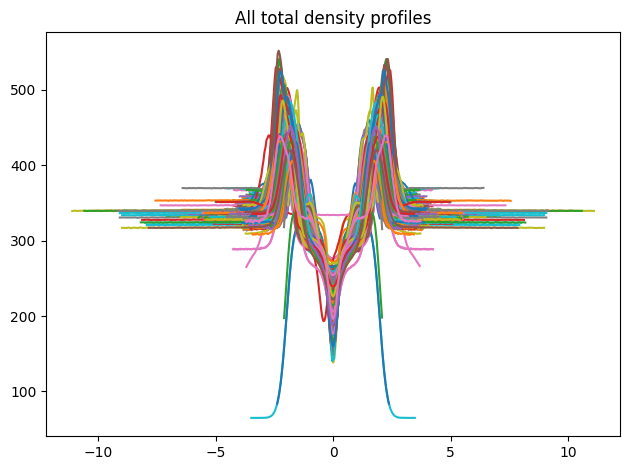

In [5]:
# Plot total density profiles
fig, ax = plt.subplots()
ax = plot_total_densities_to_ax(ax, all_td_x, all_td_y)
plt.title('All total density profiles')
plt.tight_layout()
plt.show()

### Homogenize the data format of the total densities
The model fitting requires data with a uniform format, but the dimensions of total density profiles varies between experiments. 
Furthermore, the plot of all total densities shows that some experiments have long constant tails while others are seemingly truncated in the x direction. 
Therefore, a preprocessing process is needed, both to choose a uniform x interval and to make sure the data has the same length. 

To select the x interval, one option is to constrict the x range to the most narrow observed experiment, but this leads to a loss of information for the wider experiments. 
Aother option is to extrapolate the shorter observation windows, and trim the longest tails. 

In the following code block, an x interval centered around zero is chosen.
Experiments that are narrower than this interval are extrapolated in the x direction in a simple way: using the y values at the ends of the observation window. 
This makes sure that all experiments have either measurements or extrapolated values across the x interval. 

Next, a Gaussian Process Regression is used to interpolate (predict values between points) on a uniform set of x coordinates that cover the x interval. 
This brings all the data on the same format. 

In [6]:
# Define start and end of x interval
x_interval_start = -4
x_interval_end = 4
length_of_padded_data = 400

padded_td_x = [extrapolate_X(td_x, length_of_padded_data, x_interval_start, x_interval_end) for td_x in all_td_x]
padded_td_y = [extrapolate_Y(td_y, length_of_padded_data) for td_y in all_td_y]

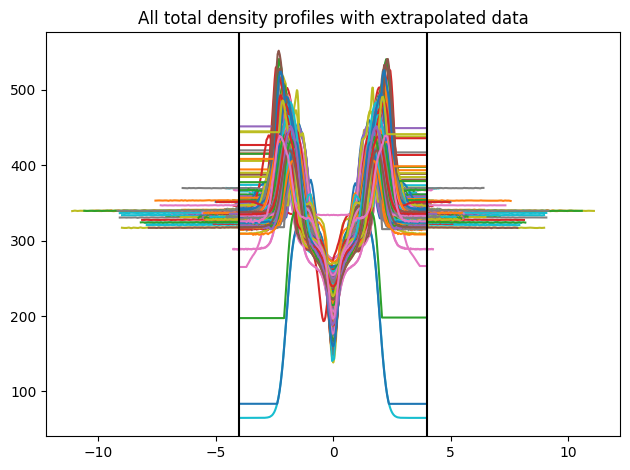

In [7]:
# Plot total density profiles
fig, ax = plt.subplots()
ax = plot_total_densities_to_ax(ax, padded_td_x, padded_td_y, lines=[x_interval_start,x_interval_end])
plt.title('All total density profiles with extrapolated data')
plt.tight_layout()
plt.show()

Rescale total densities to [0,1] range based on the max and min value among all densities.
This maintains internal differences in amplitude.

In [8]:
min_ff = min(min(sublist) for sublist in all_ff)
min_td_x = min(min(sublist) for sublist in padded_td_x)
min_td_y = min(min(sublist) for sublist in padded_td_y)

max_ff = max(max(sublist) for sublist in all_ff)
max_td_x = max(max(sublist) for sublist in padded_td_x)
max_td_y = max(max(sublist) for sublist in padded_td_y)

# Rescale by providing global min and max
def rescale(values, min_value, max_value):
    return (values - min_value) / (max_value - min_value)

# Apply to each sublist in ff and td x and y
rescaled_all_ff = [rescale(ff, min_ff, max_ff) for ff in all_ff]
rescaled_all_td_x = [rescale(td_x, min_td_x, max_td_x) for td_x in padded_td_x]
rescaled_all_td_y = [rescale(td_y, min_td_y, max_td_y) for td_y in padded_td_y]

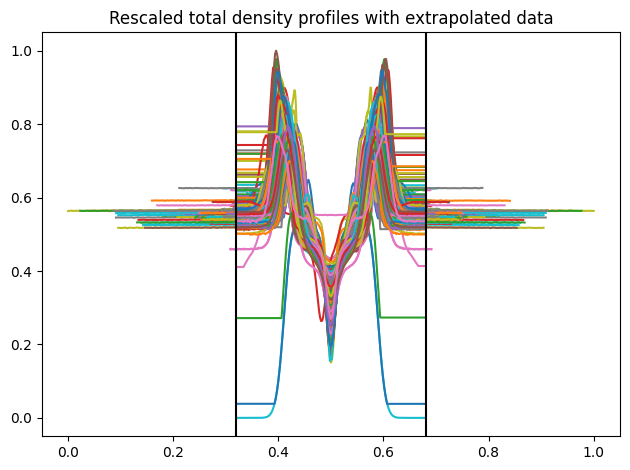

In [9]:
# Plot rescaled total density profiles

rescaled_start = rescale(x_interval_start, min_td_x, max_td_x)
rescaled_end = rescale(x_interval_end, min_td_x, max_td_x)

fig, ax = plt.subplots()
ax = plot_total_densities_to_ax(ax, rescaled_all_td_x, rescaled_all_td_y, lines=[rescaled_start,rescaled_end])
plt.title('Rescaled total density profiles with extrapolated data')
plt.tight_layout()
plt.show()

In [10]:
# Interpolate with a Gaussian Process Regression to achieve a uniform x grid

# Define the points for prediction
uniform_x_range = np.linspace(rescaled_start, rescaled_end, 200).reshape(-1, 1)

# Interpolate y values on the uniform x grid using Gaussian Process Regression (GPR)
standardized_y = interpolate_with_GPR(rescaled_all_td_x, rescaled_all_td_y, uniform_x_range)

### Gather form factors and total densities in data frames

With the databank initiated, the form factor (ff) and total density (td) data of each simulation can be extracted from the "systems" variable.
Each form factor has a shape of (1000), but the total densities have dimensions that vary. 
Therefore, the total density data are padded with nan in the x and y dimensions to ensure a uniform shape of (200,2). 
After all data is collected, the total densities are split into separate data frames td_x and td_y for each dimension.

In [11]:
# Convert the data to a pandas DataFrame
sim_FF_df = pd.DataFrame(rescaled_all_ff)
sim_TD_y_df = pd.DataFrame(standardized_y)

Get to know the data at a glance by calling the df name in a code block.

In [12]:
sim_FF_df

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
0,0.017178,0.017147,0.017056,0.016903,0.016690,0.016416,0.016081,0.015686,0.015230,0.014714,...,0.003548,0.003657,0.003764,0.003869,0.003973,0.004076,0.004177,0.004276,0.004373,0.004469
1,0.071871,0.071839,0.071744,0.071585,0.071362,0.071076,0.070727,0.070314,0.069839,0.069300,...,0.000893,0.000944,0.000994,0.001043,0.001092,0.001140,0.001188,0.001236,0.001282,0.001328
2,0.039322,0.039339,0.039389,0.039473,0.039591,0.039742,0.039927,0.040145,0.040396,0.040681,...,0.000599,0.000485,0.000382,0.000300,0.000258,0.000275,0.000341,0.000433,0.000538,0.000648
3,0.035077,0.035043,0.034942,0.034773,0.034537,0.034234,0.033863,0.033426,0.032922,0.032351,...,0.008975,0.009019,0.009061,0.009100,0.009136,0.009170,0.009201,0.009230,0.009256,0.009279
4,0.016793,0.016764,0.016679,0.016535,0.016335,0.016078,0.015763,0.015392,0.014964,0.014480,...,0.001514,0.001587,0.001660,0.001732,0.001804,0.001875,0.001945,0.002015,0.002084,0.002153
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782,0.041878,0.041852,0.041773,0.041642,0.041459,0.041224,0.040936,0.040596,0.040205,0.039761,...,0.000576,0.000614,0.000654,0.000695,0.000737,0.000780,0.000824,0.000870,0.000916,0.000964
783,0.020638,0.020608,0.020519,0.020371,0.020163,0.019897,0.019571,0.019187,0.018744,0.018242,...,0.001113,0.001168,0.001226,0.001284,0.001343,0.001403,0.001464,0.001525,0.001586,0.001648
784,0.051984,0.051954,0.051865,0.051715,0.051507,0.051238,0.050911,0.050524,0.050078,0.049573,...,0.005728,0.005785,0.005842,0.005900,0.005959,0.006017,0.006076,0.006136,0.006195,0.006255
785,0.046032,0.045998,0.045896,0.045727,0.045491,0.045187,0.044816,0.044379,0.043874,0.043303,...,0.000158,0.000142,0.000142,0.000160,0.000191,0.000229,0.000272,0.000319,0.000367,0.000416


In [13]:
sim_TD_y_df

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
0,0.539433,0.539323,0.539108,0.539338,0.539115,0.539169,0.539490,0.538366,0.536198,0.535593,...,0.533978,0.535912,0.537796,0.538353,0.538191,0.538206,0.538250,0.538189,0.538249,0.538334
1,0.549316,0.549788,0.551550,0.549749,0.547626,0.548283,0.549149,0.548906,0.549263,0.550510,...,0.547822,0.548398,0.548564,0.548790,0.550479,0.552014,0.550524,0.548257,0.548911,0.549263
2,0.557691,0.557685,0.557706,0.557694,0.557688,0.557707,0.557698,0.557683,0.557699,0.557711,...,0.558113,0.558104,0.558094,0.558106,0.558110,0.558096,0.558104,0.558106,0.558101,0.557960
3,0.546069,0.546074,0.546149,0.546096,0.546094,0.546156,0.546107,0.546070,0.546143,0.546158,...,0.544383,0.544455,0.544477,0.544406,0.544418,0.544472,0.544421,0.544427,0.544450,0.544615
4,0.554435,0.554432,0.554416,0.554429,0.554425,0.554414,0.554429,0.554432,0.554415,0.554418,...,0.553841,0.553885,0.553875,0.553843,0.553864,0.553877,0.553852,0.553867,0.553861,0.553869
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
782,0.522984,0.522985,0.522989,0.522994,0.522979,0.522989,0.522999,0.522981,0.522978,0.522999,...,0.522697,0.522698,0.522691,0.522692,0.522698,0.522693,0.522693,0.522697,0.522692,0.522659
783,0.554451,0.554445,0.554417,0.554435,0.554440,0.554412,0.554430,0.554454,0.554416,0.554399,...,0.556038,0.556047,0.555965,0.555987,0.556047,0.555989,0.555986,0.556038,0.555970,0.555785
784,0.524311,0.524315,0.524304,0.524337,0.524278,0.524315,0.524353,0.524275,0.524280,0.524382,...,0.523600,0.523685,0.523703,0.523652,0.523667,0.523690,0.523661,0.523677,0.523670,0.523667
785,0.518651,0.518871,0.518733,0.518501,0.518645,0.519178,0.519615,0.519562,0.519149,0.518848,...,0.519548,0.519299,0.518742,0.518614,0.519026,0.519342,0.519114,0.518676,0.518563,0.518724


### Plot form factors and total densities

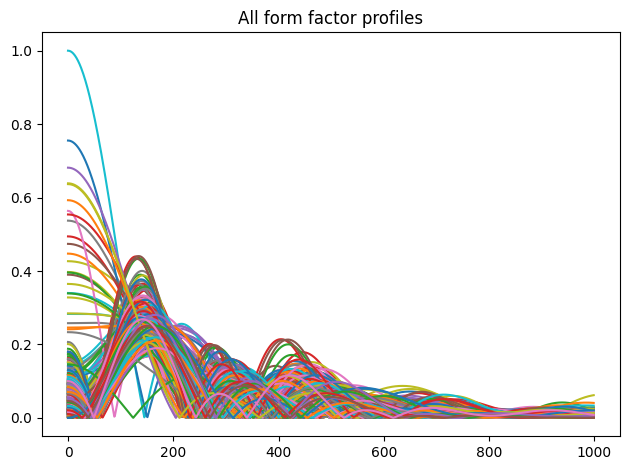

In [14]:
fig, ax = plt.subplots()
ax = plot_form_factors_to_ax(ax, sim_FF_df)
plt.title('All form factor profiles')
plt.tight_layout()
plt.show()

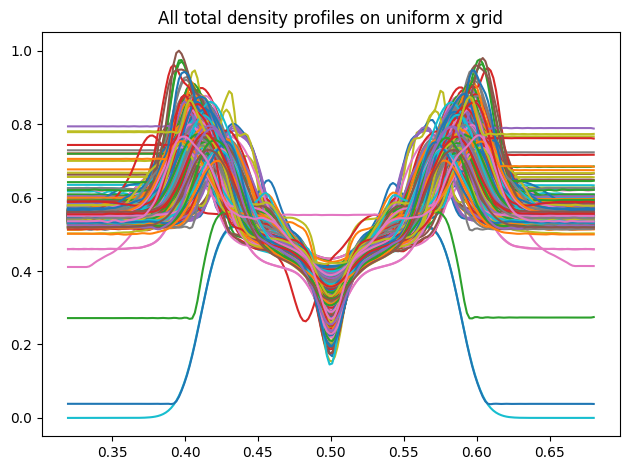

In [15]:
# Plot total density profiles on uniform x grid
fig, ax = plt.subplots()
ax = plot_total_densities_to_ax(ax, uniform_x_range, sim_TD_y_df)
plt.title('All total density profiles on uniform x grid')
plt.tight_layout()
plt.show()

Now the form factors and total densities are rescaled and on a uniform format. 

### Split data into train and test sets

In [16]:
train_input, train_output, test_input, test_output = split_train_and_test(sim_FF_df, sim_TD_y_df, rng)
N_train = train_input.shape[0]
N_test = test_input.shape[0]
print("N_train:", N_train)
print("N_test:", N_test)

N_train: 630
N_test: 157


In [17]:
train_input

,0,1,2,3,4,5,6,7,8,9,...,990,991,992,993,994,995,996,997,998,999
150,0.093309,0.093272,0.093161,0.092976,0.092718,0.092386,0.091981,0.091503,0.090951,0.090327,...,0.000705,0.000761,0.000817,0.000874,0.000930,0.000987,0.001044,0.001101,0.001157,0.001214
536,0.064981,0.064943,0.064830,0.064642,0.064378,0.064039,0.063626,0.063137,0.062574,0.061937,...,0.004635,0.004801,0.004966,0.005131,0.005296,0.005459,0.005622,0.005784,0.005945,0.006105
74,0.032678,0.032647,0.032551,0.032391,0.032168,0.031881,0.031531,0.031117,0.030640,0.030100,...,0.002398,0.002420,0.002443,0.002465,0.002487,0.002509,0.002531,0.002553,0.002575,0.002597
754,0.017237,0.017206,0.017114,0.016961,0.016747,0.016471,0.016135,0.015738,0.015280,0.014762,...,0.001607,0.001614,0.001621,0.001628,0.001634,0.001641,0.001647,0.001654,0.001660,0.001667
151,0.013712,0.013681,0.013586,0.013429,0.013209,0.012927,0.012581,0.012174,0.011704,0.011172,...,0.002769,0.002784,0.002798,0.002812,0.002824,0.002836,0.002847,0.002856,0.002865,0.002874
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,0.018978,0.018956,0.018890,0.018779,0.018625,0.018426,0.018184,0.017898,0.017568,0.017194,...,0.001563,0.001543,0.001523,0.001503,0.001482,0.001460,0.001439,0.001417,0.001394,0.001371
169,0.003264,0.003240,0.003169,0.003049,0.002882,0.002667,0.002405,0.002095,0.001738,0.001333,...,0.002366,0.002273,0.002180,0.002086,0.001993,0.001900,0.001808,0.001716,0.001625,0.001536
228,0.397424,0.397413,0.397381,0.397328,0.397252,0.397154,0.397035,0.396895,0.396733,0.396550,...,0.011119,0.011090,0.011054,0.011013,0.010966,0.010913,0.010854,0.010789,0.010718,0.010641
436,0.007224,0.007195,0.007108,0.006963,0.006760,0.006499,0.006180,0.005804,0.005370,0.004879,...,0.004284,0.004385,0.004485,0.004584,0.004681,0.004777,0.004871,0.004964,0.005056,0.005146


In [18]:
train_output

,0,1,2,3,4,5,6,7,8,9,...,190,191,192,193,194,195,196,197,198,199
150,0.551935,0.551935,0.551941,0.551934,0.551936,0.552135,0.552343,0.552243,0.552045,0.552215,...,0.552537,0.552519,0.552271,0.551978,0.551762,0.551615,0.551589,0.551621,0.551588,0.551546
536,0.562133,0.561266,0.562101,0.561031,0.561278,0.561440,0.561105,0.561124,0.561405,0.561284,...,0.560992,0.561019,0.561109,0.561309,0.561500,0.561579,0.561684,0.561765,0.560950,0.561698
74,0.548331,0.548630,0.549085,0.549192,0.549063,0.548949,0.548927,0.548971,0.549036,0.549110,...,0.548921,0.548989,0.548970,0.548955,0.549063,0.549125,0.548957,0.548768,0.548787,0.548651
754,0.556992,0.557132,0.557173,0.557087,0.556988,0.556976,0.557074,0.557200,0.557193,0.557040,...,0.557140,0.557282,0.557042,0.556605,0.556550,0.557044,0.557442,0.557211,0.556928,0.557356
151,0.566826,0.566809,0.566763,0.566752,0.566902,0.567229,0.567526,0.567491,0.567075,0.566626,...,0.566574,0.566568,0.566651,0.566621,0.566484,0.566448,0.566586,0.566728,0.566709,0.566571
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
390,0.545237,0.545239,0.545245,0.545243,0.545237,0.545246,0.545245,0.545236,0.545241,0.545250,...,0.544935,0.544949,0.544948,0.544936,0.544942,0.544948,0.544939,0.544943,0.544943,0.544958
169,0.549031,0.549030,0.549030,0.549023,0.549036,0.549029,0.549019,0.549034,0.549039,0.549020,...,0.548733,0.548757,0.548748,0.548730,0.548745,0.548752,0.548734,0.548746,0.548742,0.548770
228,0.667773,0.667787,0.667746,0.667756,0.667792,0.667744,0.667740,0.667794,0.667779,0.667722,...,0.666534,0.666597,0.666597,0.666540,0.666563,0.666604,0.666549,0.666576,0.666563,0.667266
436,0.550716,0.550728,0.550589,0.550433,0.550512,0.550744,0.550806,0.550712,0.550862,0.551348,...,0.550895,0.550875,0.551222,0.551502,0.551275,0.550758,0.550617,0.551079,0.551580,0.551481


### Train a neural net

In [19]:
general_start_time = time.time()

# This defines an Amsgrad variant of the Adam optimizer. Usually some variant 
# of Adam is first used to give an idea for performance, before other optimizers are used  
Adam = tf.keras.optimizers.Adam(amsgrad=True)

# This defines the given input to be a required_form_factor_length long vector
inputs = keras.Input(shape=(required_form_factor_length,))

# This defines a regular neural network layer of required_form_factor_length neurons using the activation function called reLu.
# ReLu is also usually used to give an idea for perfomrance, before other activation functions are used
x = layers.Dense(required_form_factor_length, activation='relu')(inputs)

# This defines an output layer, which is a regular neural network layer of 200 neurons using the 
# linear activation function, which means all neurons are activated with their weighted outputs.
outputs = layers.Dense(200, activation='linear')(x)

# This defines a model architecture
model = keras.Model(inputs=inputs, outputs=outputs)

# This compiles a model using a Adam optimizer and the intended training loss, which is mean absolute error
# Usually mean squared error is used for regression predictions, but since the output isn't suitable for it
# due to keras loss functions not knowing the division of x-axis and y-axis values, mean absolute error is used
model.compile(optimizer=Adam, loss='mean_absolute_error')

# This used the given training data to traing the model with 
# max 1500 epochs, validation split of 20 % and a training batch size of 128.
# Usually epoch amounts are around 20 to 100, which is why we are giving the model a lot of tries to adjust
# The given batch size divides the available training data of 490 into 128,128,128 and 106 separate batches 
# that are used to train the network. Larger batch sizes make the network converge faster, while smaller batch sizes 
# make the network updates more granural, increasing the used time 
history = model.fit(train_input, train_output, batch_size=128, epochs=1500, validation_split=0.2, callbacks=[EarlyStopping(monitor='val_loss', mode='min', patience=100, restore_best_weights=True)], verbose=0)

# Time use
general_end_time = time.time()
print('Used time: ' + str(general_end_time - general_start_time) + ' seconds')

Used time: 42.89549469947815 seconds


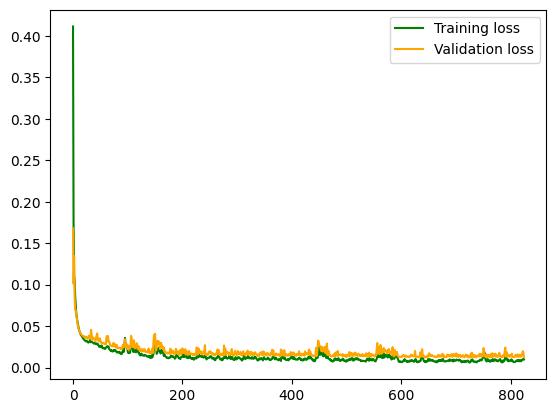

In [20]:
# Plot the training history of the model
fig, ax = plt.subplots()
ax = plot_training_trajectory(ax, history)
plt.show()

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


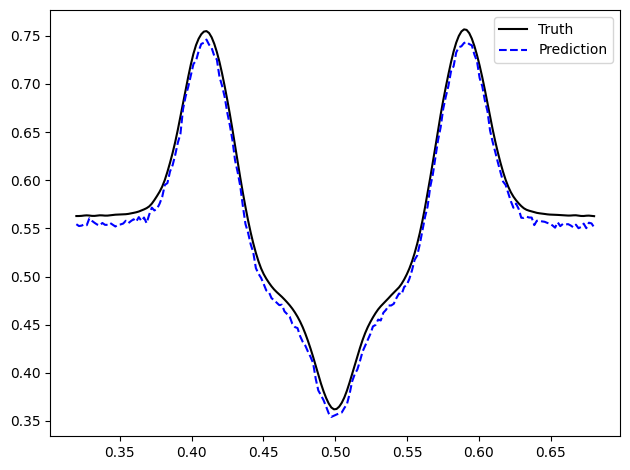

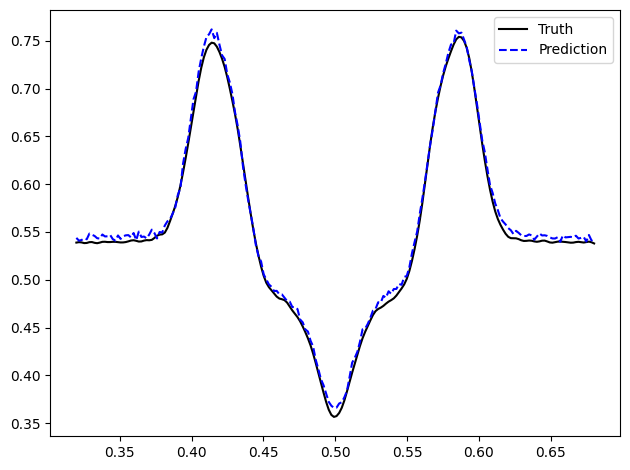

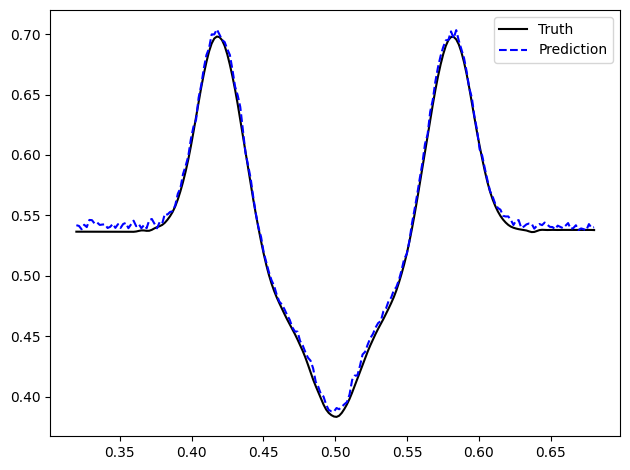

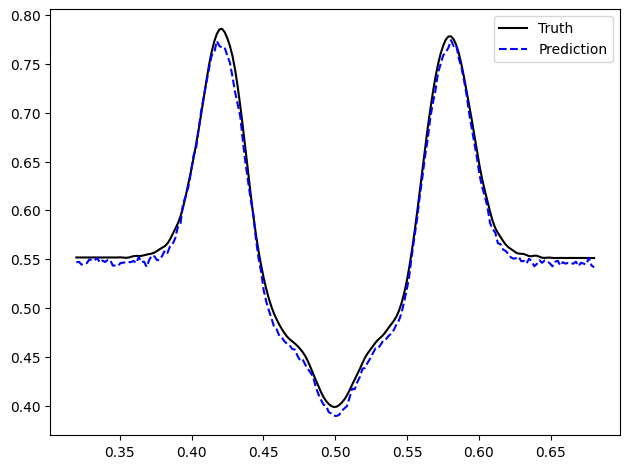

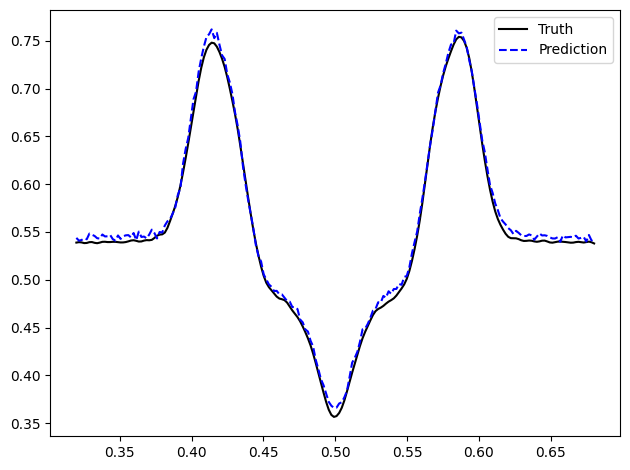

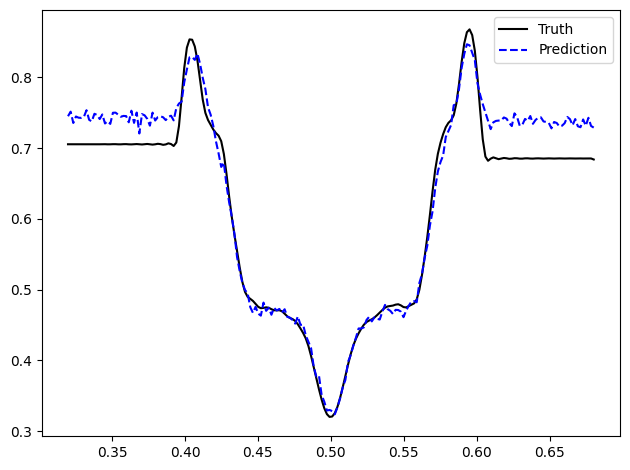

In [21]:
# Compare predictions to truth for five randomly chosen test cases
predictions = model.predict(test_input)
random_test_indices = rng.integers(low=0, high=N_test, size=6)
for idx in random_test_indices:
    fig, ax = plt.subplots()
    ax.plot(uniform_x_range, test_output.values[idx], color="k", linestyle="-", label="Truth")
    ax.plot(uniform_x_range, predictions[idx], color="b", linestyle="--", label="Prediction")
    plt.legend(loc="upper right")
    plt.tight_layout()
    plt.show()